# Anomaly Detection with Autoencoder



We are going to implement an autoencoder to perform unsupervised anomaly detection on the voltage Time series. We are going to train our model in our normal dataset and then we will test it on the given abnormal dataset to test its ability to spot anomalies.

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import seaborn as sns
from pylab import rcParams
from sklearn.utils import shuffle
from pdb import set_trace
import matplotlib.pylab as plt
import sys
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.utils.multiclass import unique_labels

In [2]:
sys.path.append('/home/aggelos-i3/ForecastingLib/')
from tsutils import SequenceSpliter
from utils import utilities

In [3]:
rcParams['figure.figsize'] = 18, 10
sns.set()

## Preprocessing

In this step we chose the features our model is going to use

In [4]:
LOOKBACK = 100
LOOK_AHEAD = 1
ROLL_WINDOW = 10
features=['voltage [V]', 
          'acceleration (actual) [m/(s*s)]', 
          'tractive effort (actual) [kN]',
           'track-earth voltage [V]',
          'speed (actual) [km/h]',
          'current [A]',
          'energy balance [kWh]',
          'way (actual) [km]',
          'line and running resistance [kN]',
          'train configuration [1]',
          'energy input [kWh]',
          'train configuration [1]',
          'usable braking energy [kWh]',
          'used braking energy [kWh]'
         ]
nb_features = len(features)

In [5]:
df_new = pd.DataFrame()
s = 0.
pathlist = Path("/home/aggelos-i3/Downloads/simu Elbas/7h33NO").glob(
    '**/*.xls')
for path in pathlist:
    path_in_str = str(path)
    df = pd.read_csv(path_in_str, delimiter='\t', usecols=features)
    if df_new.empty:
        df_new = df[:1000]
    else:
        df_new += df[:1000]
    s += 1.

df_new /= s
#distance = df['way (actual) [km]'] 
df_new = df_new.rolling(window=ROLL_WINDOW).mean().dropna()
#df_new['way (actual) [km]'] = distance

In [6]:
df_new.head(20)

,way (actual) [km],speed (actual) [km/h],voltage [V],current [A],track-earth voltage [V],energy input [kWh],energy balance [kWh],usable braking energy [kWh],used braking energy [kWh],tractive effort (actual) [kN],line and running resistance [kN],acceleration (actual) [m/(s*s)],train configuration [1]
9,0.015949,9.385,783.912412,145.606632,-0.683911,0.276194,0.276194,0.000000,0.000000,24.306876,9.739141,0.251389,2.0
10,0.021737,11.455,782.841094,175.233619,-0.533764,0.352158,0.352158,0.000000,0.000000,27.618615,10.958278,0.287500,2.0
11,0.028692,13.580,782.433733,185.736624,-0.430455,0.432672,0.432672,0.000000,0.000000,28.150091,11.047088,0.295139,2.0
12,0.036781,15.540,782.201914,191.760017,-0.287337,0.515797,0.515797,0.000000,0.000000,26.777494,11.002489,0.272222,2.0
13,0.045853,17.120,782.152649,189.357874,-0.203874,0.597876,0.597876,0.000000,0.000000,23.563321,10.846734,0.219444,2.0
14,0.055632,18.085,782.627481,172.272490,-0.222331,0.672903,0.672538,0.001118,0.001118,18.452913,10.686137,0.134028,2.0
15,0.065822,18.600,782.692811,155.532093,-0.247510,0.740657,0.739926,0.002785,0.002785,14.660855,10.515891,0.071528,2.0
16,0.076226,18.855,783.115180,136.680714,-0.322162,0.802985,0.799088,0.008004,0.008004,12.390403,10.338042,0.035417,2.0
17,0.086692,18.820,784.431443,119.688525,-0.373717,0.861845,0.850766,0.017993,0.017993,9.852077,10.133773,-0.004861,2.0
18,0.097061,18.510,785.369679,105.076672,-0.329957,0.915085,0.896087,0.029473,0.029472,7.331346,9.826372,-0.043056,2.0


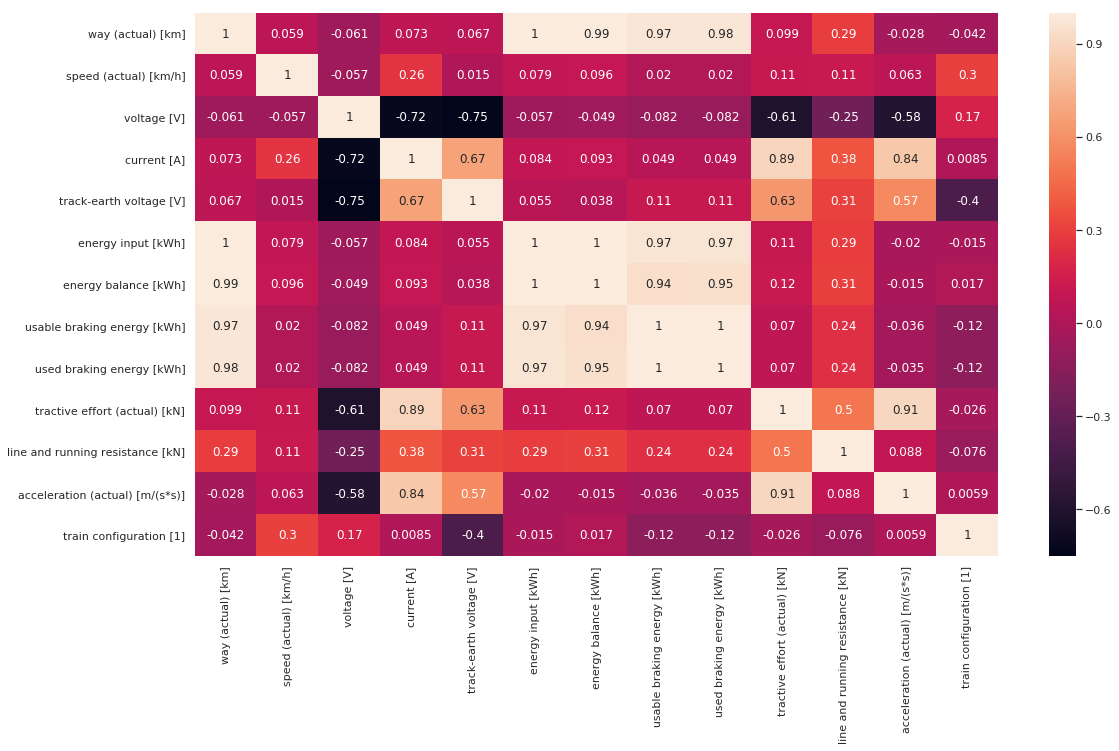

In [7]:
var_corr = df_new.corr()
sns.heatmap(var_corr, xticklabels=var_corr.columns, yticklabels=var_corr.columns, annot=True)

In [8]:
def plot_im(array):
    array = pd.DataFrame(array)
    sns.heatmap(array, xticklabels=array.columns, yticklabels=array.columns, annot=True)

In [9]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler()
y_idx = df_new.columns.get_loc('voltage [V]') #which series we try to replicate
scaler = scaler.fit(df_new)
df_scaled = scaler.transform(df_new)
spliter = SequenceSpliter(lookback=LOOKBACK, look_ahead=LOOK_AHEAD)

In [10]:
X, y = spliter.fit_transform(df_scaled)

In [11]:
#X = np.delete(X, y_idx, 2)
# we need to forecast only the voltage
y = y[:, :, y_idx] 

In [14]:
X_new = np.zeros((X.shape[0], X.shape[2], X.shape[2]))
for i in range(len(X)):
    X_new[i] = np.corrcoef(X[i,:,:], rowvar=False)

X_new = X_new.reshape(X_new.shape[0], X_new.shape[1], X_new.shape[2], 1)
X_new.shape

In [42]:
inputs = Input(shape=X_new.shape[1:])
encoder = Conv2D(100, (6,6), padding='same')(inputs)
encoder = BatchNormalization()(encoder)
encoder = Activation('relu')(encoder)
encoder = Conv2D(16, (4,4), padding='same')(encoder)
encoder = BatchNormalization()(encoder)
encoder = Activation('relu')(encoder)
encoder = Conv2D(8, (2,2), padding='same')(encoder)
encoder = BatchNormalization()(encoder)
encoder = Activation('relu')(encoder)
decoder = Conv2D(1, (4,4), padding='same')(encoder)
decoder = BatchNormalization()(decoder)
decoder = Activation('relu')(decoder)
out = Conv2D(1, (6,6), padding='same')(decoder)
#out = GlobalAveragePooling2D()(decoder)
#out = Dense(LOOKBACK)(decoder)
FCN_AE = Model(inputs, decoder)
FCN_AE.compile(loss='mse', optimizer='adam')
FCN_AE.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 13, 13, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 100)       3700      
_________________________________________________________________
batch_normalization_8 (Batch (None, 13, 13, 100)       400       
_________________________________________________________________
activation_8 (Activation)    (None, 13, 13, 100)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 13, 13, 16)        25616     
_________________________________________________________________
batch_normalization_9 (Batch (None, 13, 13, 16)        64        
_________________________________________________________________
activation_9 (Activation)    (None, 13, 13, 16)        0         
__________

Train on 801 samples, validate on 90 samples
Epoch 1/25
801/801 [==============================] - 1s 2ms/step - loss: 5.3585 - val_loss: 6.3224
Epoch 2/25
801/801 [==============================] - 1s 1ms/step - loss: 2.2449 - val_loss: 4.8005
Epoch 3/25
801/801 [==============================] - 1s 1ms/step - loss: 2.0179 - val_loss: 4.5284
Epoch 4/25
801/801 [==============================] - 1s 1ms/step - loss: 1.9334 - val_loss: 4.4009
Epoch 5/25
801/801 [==============================] - 1s 997us/step - loss: 1.8956 - val_loss: 4.2579
Epoch 6/25
801/801 [==============================] - 1s 1ms/step - loss: 1.8676 - val_loss: 4.0612
Epoch 7/25
801/801 [==============================] - 1s 1ms/step - loss: 1.8394 - val_loss: 3.8919
Epoch 8/25
801/801 [==============================] - 1s 999us/step - loss: 1.8223 - val_loss: 3.6946
Epoch 9/25
801/801 [==============================] - 1s 1ms/step - loss: 1.8164 - val_loss: 3.4706
Epoch 10/25
801/801 [==============================

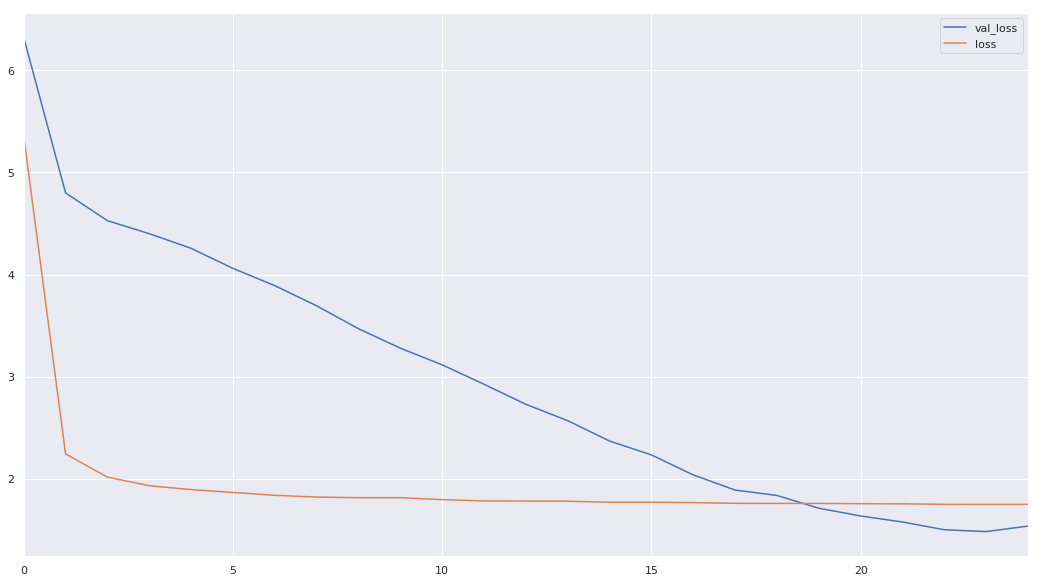

In [43]:
history = FCN_AE.fit(X_new, X_new, epochs=25, validation_split=0.1)
history = pd.DataFrame(history.history)
history.plot()

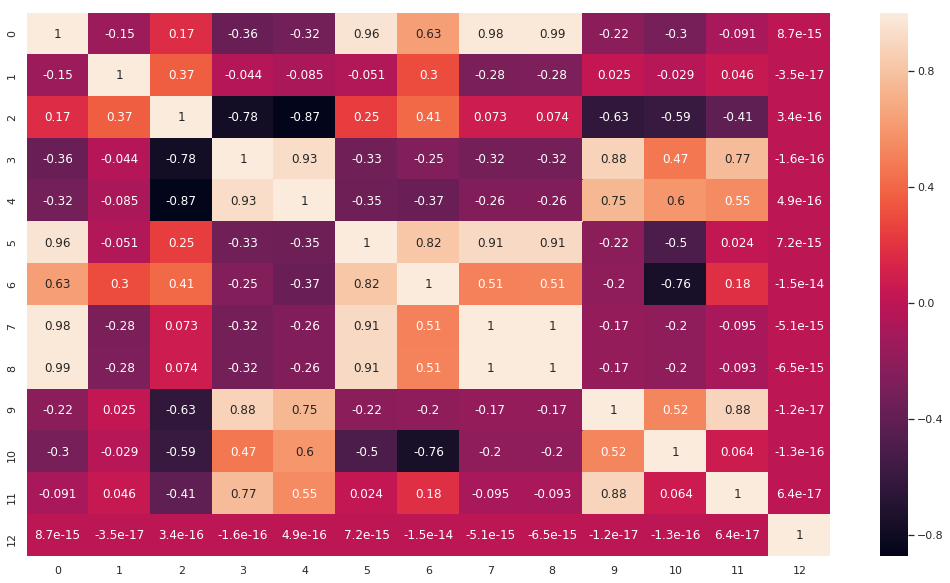

In [44]:
plot_im(X_new[10,:,:,0])

In [45]:
yhat = FCN_AE.predict(X_new)

In [87]:
ERROR_TYPE = [1, 2, 3] #we can hav different labels for each error or the same label?
threshold = 0.4
max_range = 800
min_range = 0
DATASET_IDX = 0

def model_test(model, threshold, dataset_idx):
    i=1
    for error_type in ERROR_TYPE:
        df_faulty = pd.DataFrame()
        s = 0.
        pathlist = Path(f"/home/aggelos-i3/Downloads/simu Elbas/7h33D{error_type}").glob(
            '**/*.xls')

        for path in pathlist:
            path_in_str = str(path)
            df = pd.read_csv(path_in_str, delimiter='\t', usecols=features)
            if df_faulty.empty:
                df_faulty = df[:1000]
            else:
                df_faulty += df[:1000]
            s += 1.

        df_faulty /= s
        df_faulty = df_faulty.rolling(window=ROLL_WINDOW).mean().dropna()
        y_idx = df_faulty.columns.get_loc('voltage [V]')
        df_scaled_faulty = scaler.fit_transform(df_faulty)
        X_test, y_test = spliter.fit_transform(df_scaled_faulty)
        X_new = np.zeros((X.shape[0], X.shape[2], X.shape[2]))
        for i in range(len(X)):
            X_new[i] = np.corrcoef(X[i,:,:], rowvar=False)
        
        X_test = X_new.reshape(X_new.shape[0], X_new.shape[1], X_new.shape[2], 1)
        #X_test = np.delete(X_test, y_idx, 2)
        y_test = y_test[:, :, y_idx]

        yhat = model.predict(X_test)
        #yhat = yhat.reshape(X_test.shape)
        mse = np.mean(np.mean(np.power(yhat-X_test,2), axis=1), axis=1)
        #df_error = pd.DataFrame({'reconstruction_error': mse,
        #                         'Label': y_test[:,0]})
        #df_error = df_error[:max_range]
        #df_error['reconstruction_error'].plot()
        anomaly = mse[min_range:max_range] > threshold
        print(mse.shape)
        #lt.subplot(3,1,i)
        plt.plot(mse)

        #plt.title(f"Error Type {error_type}")
        #plt.plot(df_error['reconstruction_error'][min_range:], label='Reconstruction Error')

        #plt.subplot(3,2,i+1)
        #plt.scatter(range(min_range,max_range), np.where(anomaly, y_test[min_range:max_range, 0], None), c='r', label='Outliers')
        #plt.plot(range(min_range,max_range), y_test[min_range:max_range,0], label='Abnormal Voltage')
        #plt.plot(range(min_range,max_range), y[min_range:max_range,0], label='Normal Voltage')
        #plt.plot(range(max_range), yhat[:max_range,0], label='Predicted Voltage')

        #lt.legend(loc='best')
        i+=1
    

(891, 1)
(891, 1)
(891, 1)


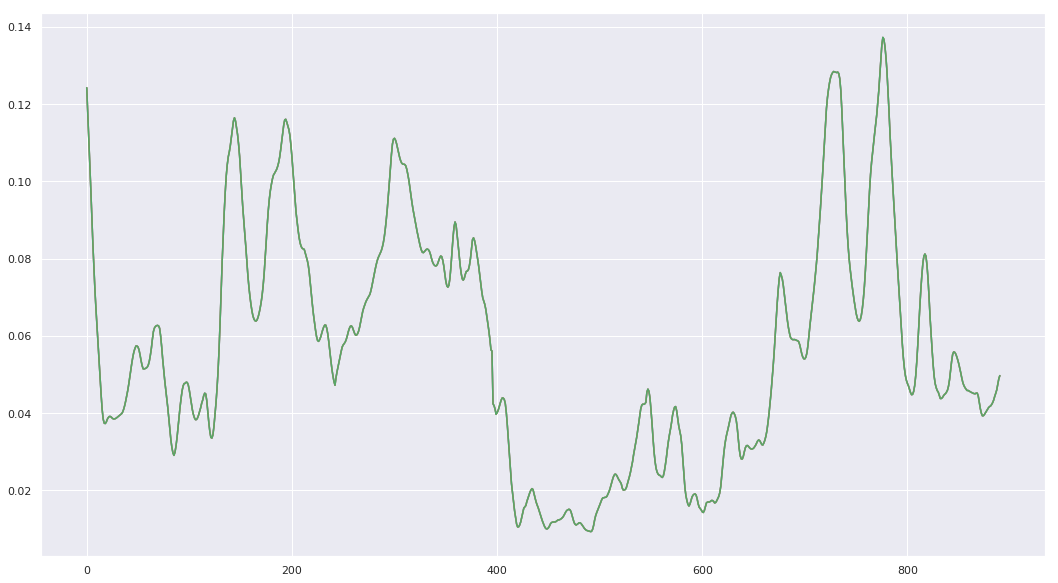

In [88]:

model_test(FCN_AE, 0.3, dataset_idx=10)